# 2 Stages
1. No differencing
2. With differencing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# ML for Forecasting w/o Differncing

In [10]:
df = pd.read_csv("../Data/perrin-freres-monthly-champagne.csv",
                 index_col = 'Month',
                 skipfooter = 2,
                 parse_dates = True)

df.columns = ['Sales']
df['LogSales'] = np.log(df['Sales'])

# Split train and test
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]


series = df['LogSales'].to_numpy()


# Create AR like data
T = 12
X = []
Y = []

for t in range(len(series) - T):
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
# Reshape Data
X = np.array(X).reshape(-1,T)
Y = np.array(Y)
print(Y.shape)
N = len(X)

(93,)


/var/folders/09/t5f173_57wj_mzwtx_28y9y80000gn/T/ipykernel_87548/1577690766.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("../Data/perrin-freres-monthly-champagne.csv",


# Linear model

In [11]:
# Split train and test
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
print("Train R^2:",lr.score(Xtrain, Ytrain))
print("Test R^2:",lr.score(Xtest, Ytest))

Train R^2: 0.8682372095559
Test R^2: 0.9657520752272787


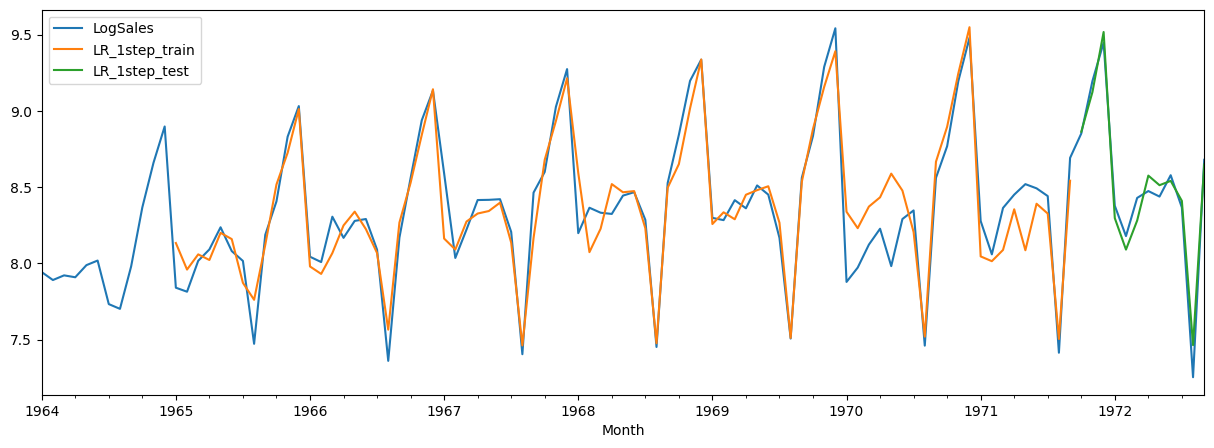

In [13]:
# Boolean indexing
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# Fist T values are not predictable
train_idx[:T] = False


# 1-step forecast
df.loc[train_idx, "LR_1step_train"] = lr.predict(Xtrain)
df.loc[test_idx, "LR_1step_test"] = lr.predict(Xtest)


# plot 1-step forecast
df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize = (15, 5));

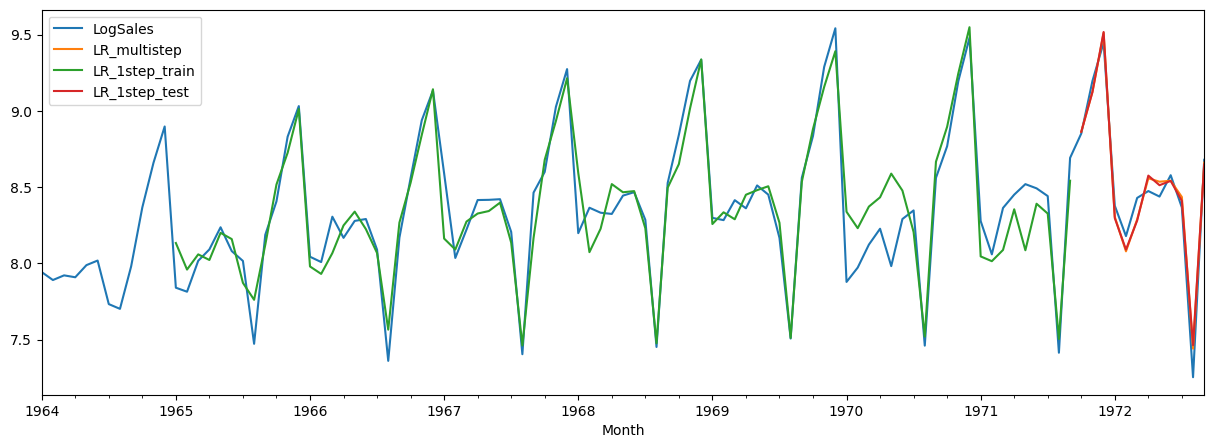

In [14]:
# Multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]
    
    multistep_predictions.append(p)
    
    last_x = np.roll(last_x,-1) # [1,2,3] -> [2,3,1]
    last_x[-1] = p # Replace the last value with the predicted value

# Save prediction
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

# plot 1-step, multistep forecast
df[['LogSales', 'LR_multistep','LR_1step_train', 'LR_1step_test']].plot(figsize = (15, 5));

# Multi-output Model

In [20]:
# Create AR like data
Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t: t+Tx]
    X.append(x)
    
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    

# Reshape Data
X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print('X.shape', X.shape, 'Y.shpae', Y.shape)



X.shape (82, 12) Y.shpae (82, 12)


In [23]:
# Split train and test
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
print("Train R^2:",lr.score(Xtrain_m, Ytrain_m))
print("Test R^2:",lr.score(Xtest_m, Ytest_m))

Train R^2: 0.8829262390390559
Test R^2: nan


/Users/yunjaecho/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


<Axes: xlabel='Month'>

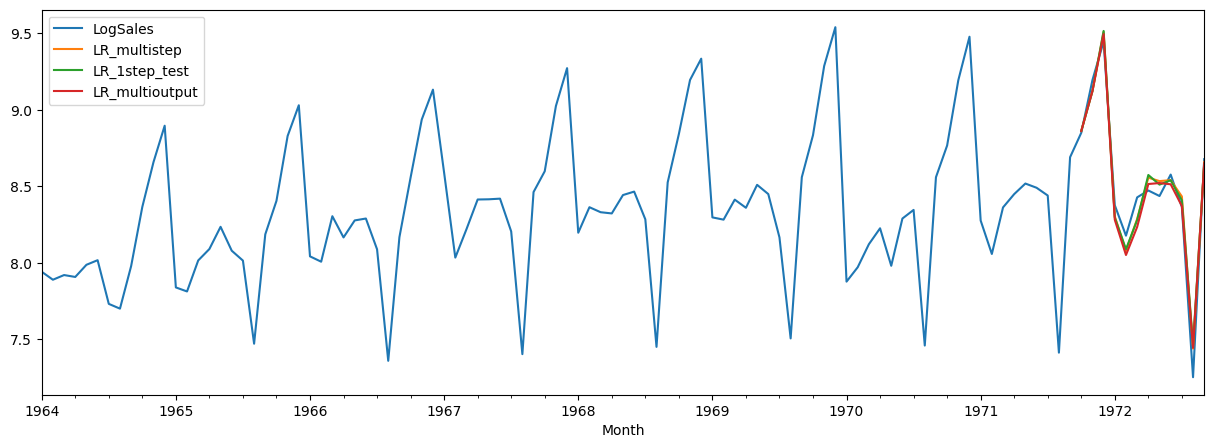

In [24]:
# Save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize = (15,5))

In [25]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("Mape1: ", mape1)

mape2 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, 'LR_multioutput'])
print("Mape2: ", mape2)

Mape1:  0.009607169373797695
Mape2:  0.009727020853255806


# Test Other Models

In [30]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One step forecast", name)
    
    df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
    df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)
    # Multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]

        multistep_predictions.append(p)

        last_x = np.roll(last_x,-1) # [1,2,3] -> [2,3,1]
        last_x[-1] = p # Replace the last value with the predicted value

    df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print("Mape: ", mape)

        
    cols = ['LogSales', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    df[cols].plot(figsize = (15,5))

One step forecast SVR
Mape:  0.013188370472848111


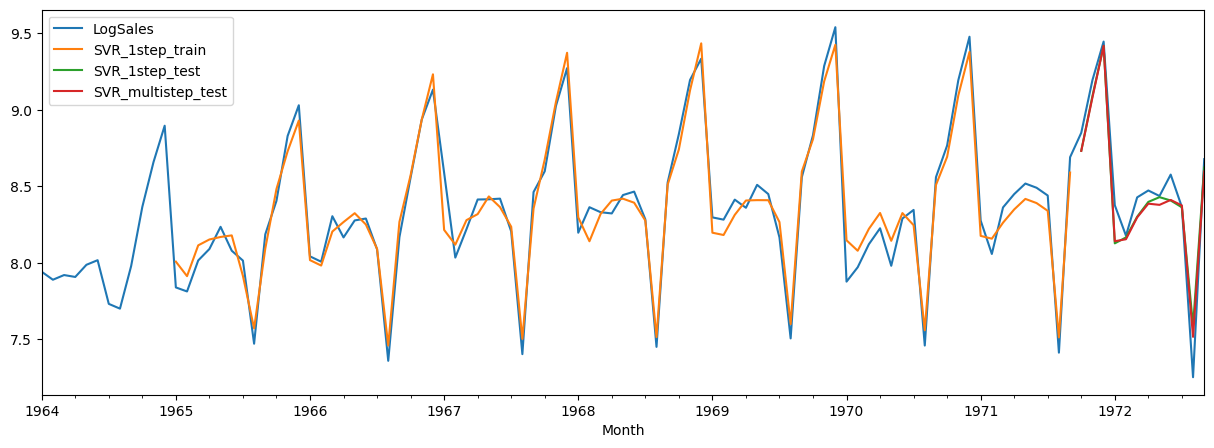

In [31]:
one_step_and_multistep_forecast(SVR(), "SVR")

One step forecast RF
Mape:  0.01241692923094762


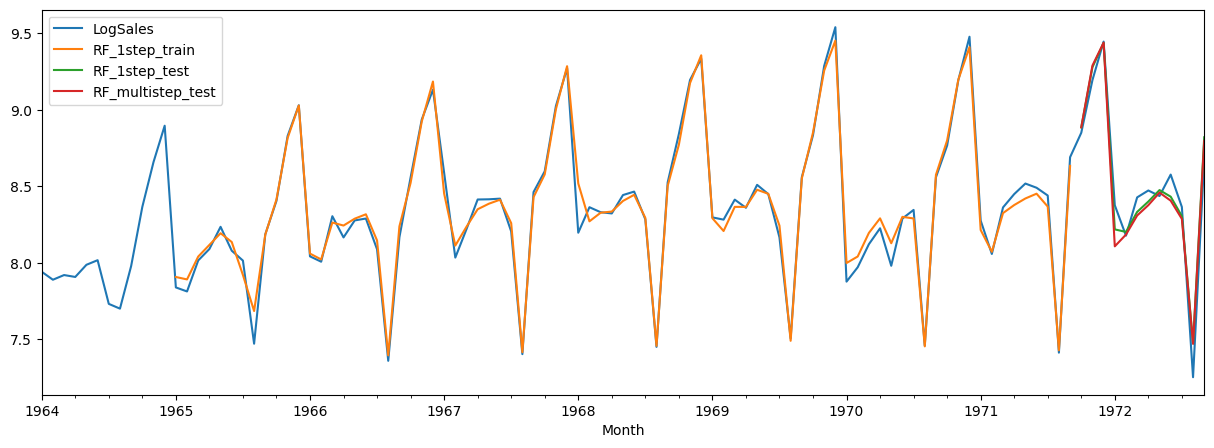

In [32]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [35]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)
    
    # save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()
    
    mape = mean_absolute_percentage_error(Ytest, df.loc[test_idx, f'{name}_multioutput'])
    print("Mape: ", mape)
    
    cols = ['LogSales', 
            f'{name}_1step_train', 
            f'{name}_1step_test',
            f'{name}_multistep_test',
            f'{name}_multioutput'
           ]
    df[cols].plot(figsize = (15,5))

Mape:  0.018494634849315395


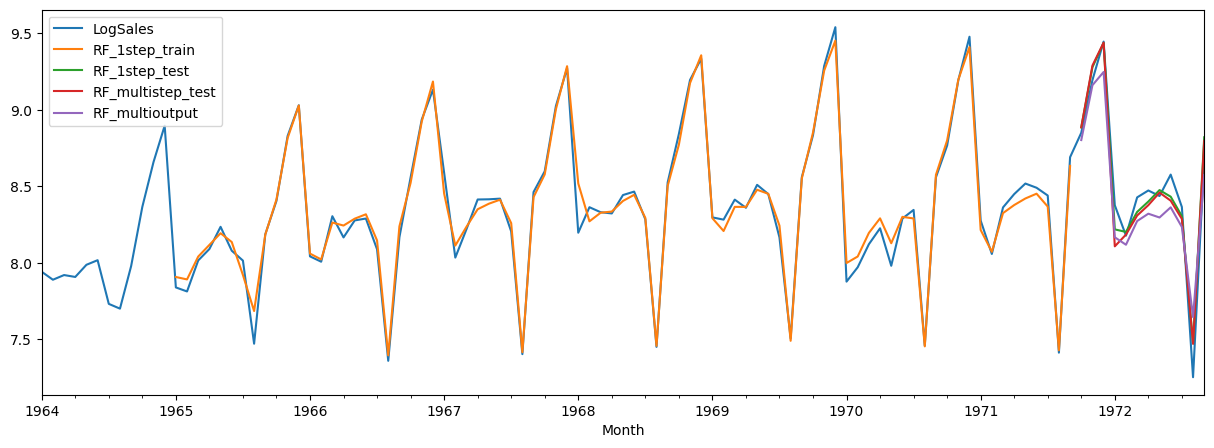

In [36]:
multi_output_forecast(RandomForestRegressor(), "RF")